# Import

In [1]:
import pandas as pd
import torch
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import copy

In [157]:
import os
import re
import string
import json
import numpy as np
from sklearn import metrics
from bs4 import BeautifulSoup
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
import nltk
pd.set_option("display.max_columns", None)

# Data

ref: [kaggle](https://www.kaggle.com/datasets/mazlumi/mbti-personality-type-twitter-dataset/code)

In [4]:
df2 = pd.read_csv('./dataset/twitter_MBTI.csv').iloc[:,1:]

In [5]:
df2

,text,label
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,@Hispanthicckk Being you makes you look cute||...,intj
2,@Alshymi Les balles sont réelles et sont tirée...,intj
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj
...,...,...
7806,"@sobsjjun God,,pls take care 😕|||@sobsjjun Hir...",intp
7807,@Ignis_02 wow last time i got intp https://t.c...,intp
7808,@akupilled A 100%|||@akupilled That SOMEONE wi...,entp
7809,If you’re #INTJ this one is for you | What is ...,infj


In [6]:
df_t = pd.read_csv('./dataset/mbti_1.csv')

In [7]:
df_t

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [8]:
df_t.iloc[1,:]

type                                                  ENTP
posts    'I'm finding the lack of me in these posts ver...
Name: 1, dtype: object

(array([ 781.,  811.,  279.,  577., 1057., 1282.,  518.,  729.,  259.,
         364.,   81.,  105.,  327.,  367.,  100.,  174.]),
 array([ 0.    ,  0.9375,  1.875 ,  2.8125,  3.75  ,  4.6875,  5.625 ,
         6.5625,  7.5   ,  8.4375,  9.375 , 10.3125, 11.25  , 12.1875,
        13.125 , 14.0625, 15.    ]),
 <BarContainer object of 16 artists>)

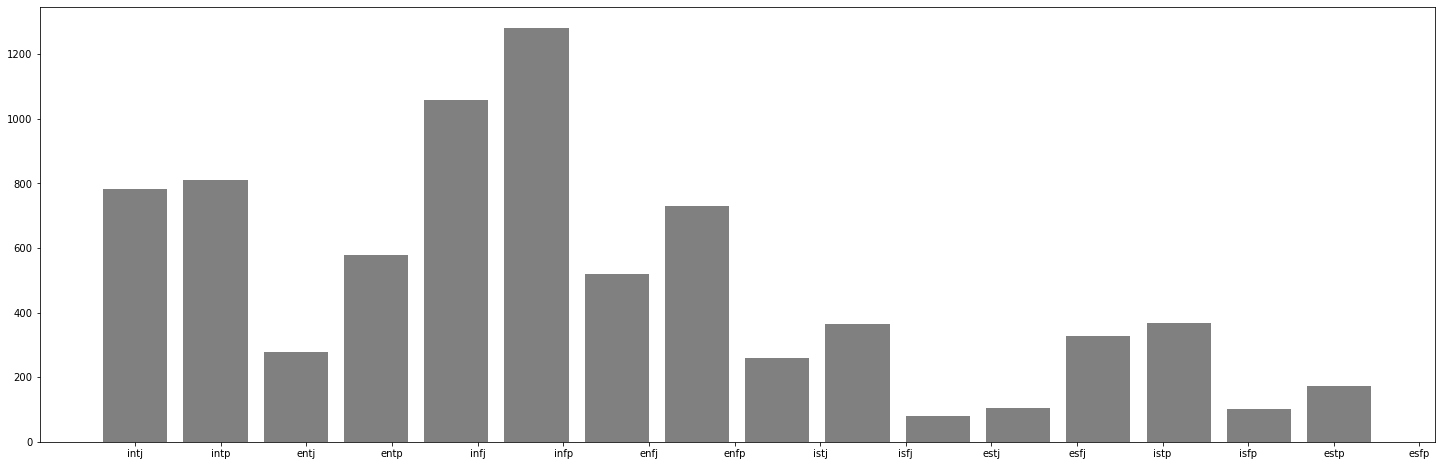

In [9]:
plt.figure(figsize=(25, 8))
plt.hist(df2['label'],color='grey', align='left', rwidth=0.8,bins=16)

(array([1470.,  685., 1304., 1091.,  231.,  190., 1832.,  675.,  271.,
         337.,  166.,  205.,   89.,   48.,   39.,   42.]),
 array([ 0.    ,  0.9375,  1.875 ,  2.8125,  3.75  ,  4.6875,  5.625 ,
         6.5625,  7.5   ,  8.4375,  9.375 , 10.3125, 11.25  , 12.1875,
        13.125 , 14.0625, 15.    ]),
 <BarContainer object of 16 artists>)

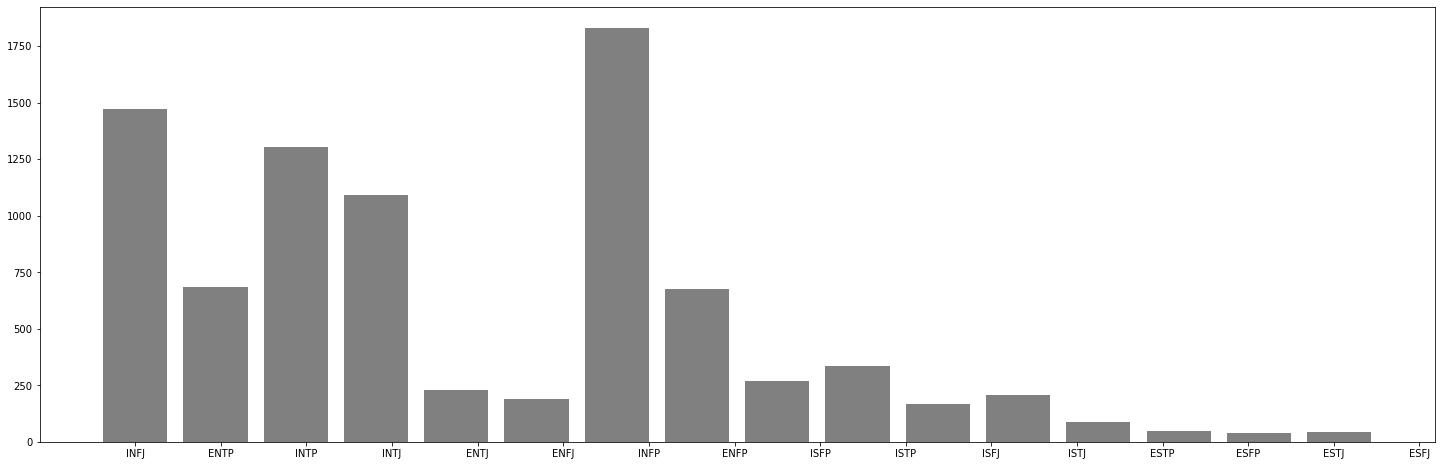

In [10]:
plt.figure(figsize=(25, 8))
plt.hist(df_t['type'],color='grey', align='left', rwidth=0.8,bins=16)

In [11]:
df2['word_count'] = df2['text'].apply(lambda x: len(x.split()))

In [12]:
df_t['word_count'] = df_t['posts'].apply(lambda x: len(x.split()))

(array([109.,  94.,  89.,  99.,  99., 102., 153., 106., 124., 149., 151.,
        162., 140., 161., 155., 221., 229., 218., 210., 202., 220., 209.,
        192., 240., 207., 188., 184., 186., 182., 187., 185., 160., 174.,
        155., 133., 116., 121., 123., 130., 118.,  99.,  90.,  91.,  84.,
         88.,  68.,  64.,  57.,  70.,  58.,  42.,  44.,  53.,  43.,  47.,
         42.,  30.,  37.,  42.,  15.,  21.,  27.,  26.,  14.,  18.,   9.,
         13.,  19.,  14.,  20.,   7.,  12.,   3.,  11.,   4.,   3.,   4.,
          4.,   1.,   4.,   5.,   3.,   3.,   5.,   2.,   4.,   2.,   0.,
          1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          1.]),
 array([ 201.  ,  242.43,  283.86,  325.29,  366.72,  408.15,  449.58,
         491.01,  532.44,  573.87,  615.3 ,  656.73,  698.16,  739.59,
         781.02,  822.45,  863.88,  905.31,  946.74,  988.17, 1029.6 ,
        1071.03, 1112.46, 1153.89, 1195.32, 1236.75, 1278.18, 1319.61,
        1361.04, 1402.47, 1443.9 ,

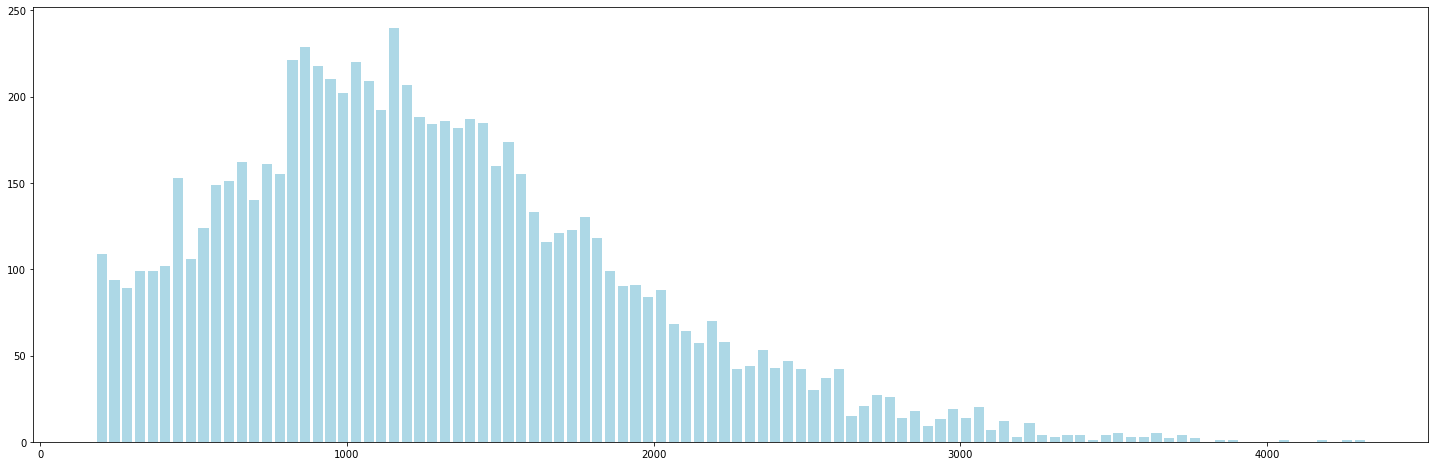

In [13]:
plt.figure(figsize=(25, 8))
plt.hist(df2['word_count'],color='lightblue', align='left', rwidth=0.8,bins=100)

(array([  2.,   1.,   4.,   2.,   1.,   1.,   3.,   3.,   2.,   9.,   4.,
          7.,   4.,   8.,   9.,   9.,  10.,  13.,   8.,  17.,  13.,  17.,
         18.,  22.,  28.,  16.,  22.,  24.,  31.,  30.,  36.,  35.,  31.,
         26.,  42.,  38.,  51.,  43.,  43.,  53.,  70.,  53.,  70.,  89.,
         66.,  88.,  85.,  67., 104., 100., 111., 116.,  96., 139., 108.,
        135., 138., 128., 167., 145., 156., 187., 185., 161., 211., 207.,
        211., 249., 224., 203., 243., 235., 220., 206., 260., 239., 212.,
        210., 206., 227., 211., 180., 157., 179., 155., 153., 107., 126.,
         84.,  66.,  52.,  37.,  39.,  33.,  12.,   8.,   5.,   4.,   3.,
          1.]),
 array([   4.  ,   22.77,   41.54,   60.31,   79.08,   97.85,  116.62,
         135.39,  154.16,  172.93,  191.7 ,  210.47,  229.24,  248.01,
         266.78,  285.55,  304.32,  323.09,  341.86,  360.63,  379.4 ,
         398.17,  416.94,  435.71,  454.48,  473.25,  492.02,  510.79,
         529.56,  548.33,  567.1 ,

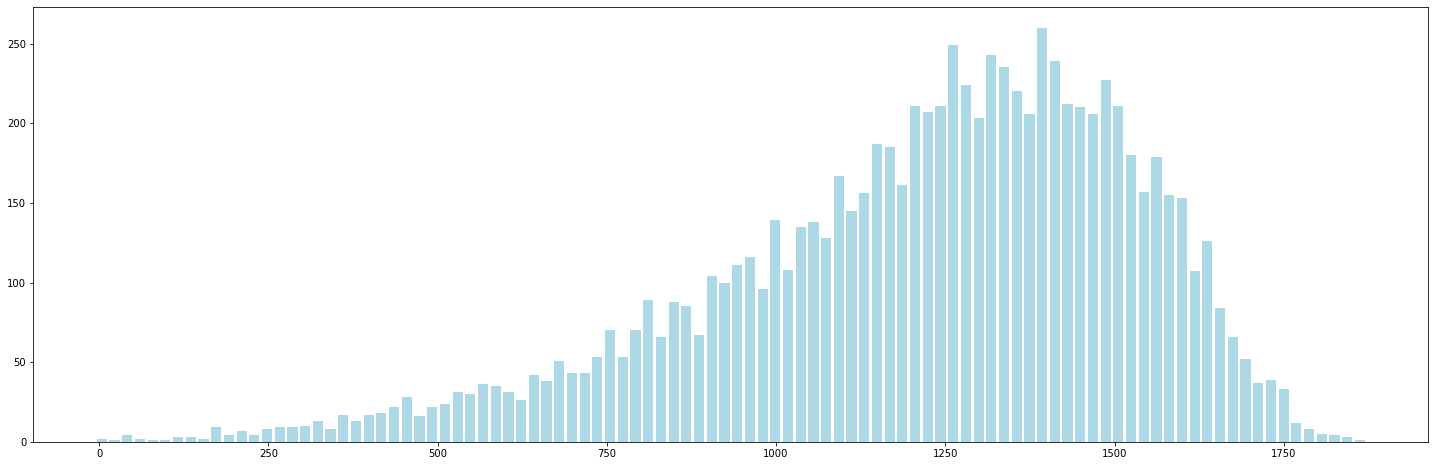

In [14]:
plt.figure(figsize=(25, 8))
plt.hist(df_t['word_count'],color='lightblue', align='left', rwidth=0.8,bins=100)

https://wikidocs.net/152922

https://dacon.io/codeshare/5619

https://www.kaggle.com/code/debarshichanda/bert-multi-label-text-classification

https://www.kaggle.com/datasets/datasnaek/mbti-type?select=mbti_1.csv

In [15]:
one = pd.get_dummies(df2['label'], prefix='label')

In [16]:
one_t = pd.get_dummies(df_t['type'], prefix='type')

In [17]:
df3 = pd.concat([df2,one],axis=1)

In [18]:
df_t1 = pd.concat([df_t,one_t],axis=1)

In [19]:
df3.head()

,text,label,word_count,label_enfj,label_enfp,label_entj,label_entp,label_esfj,label_esfp,label_estj,label_estp,label_infj,label_infp,label_intj,label_intp,label_isfj,label_isfp,label_istj,label_istp
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj,2351,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,@Hispanthicckk Being you makes you look cute||...,intj,943,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,@Alshymi Les balles sont réelles et sont tirée...,intj,1646,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj,923,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj,1024,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [20]:
df_t1.head()

,type,posts,word_count,type_ENFJ,type_ENFP,type_ENTJ,type_ENTP,type_ESFJ,type_ESFP,type_ESTJ,type_ESTP,type_INFJ,type_INFP,type_INTJ,type_INTP,type_ISFJ,type_ISFP,type_ISTJ,type_ISTP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,556,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1170,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,836,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1064,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,ENTJ,'You're fired.|||That's another silly misconce...,967,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
def clean_text(text):
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [22]:
df_t2 = df_t1.copy().reset_index()

### Data Clean

In [23]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}


In [24]:
df_t2['posts'] = df_t2['posts'].apply(text_preprocessing_pipeline)

In [25]:
df_t2.head()

,index,type,posts,word_count,type_ENFJ,type_ENFP,type_ENTJ,type_ENTP,type_ESFJ,type_ESFP,type_ESTJ,type_ESTP,type_INFJ,type_INFP,type_INTJ,type_INTP,type_ISFJ,type_ISFP,type_ISTJ,type_ISTP
0,0,INFJ,http mediatumblrcom jpg enfp and intj moments ...,556,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,ENTP,i am finding the lack of me in these posts ver...,1170,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,INTP,good one https dozens of different plant speci...,836,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,INTJ,dear intp i enjoyed our conversation the other...,1064,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,4,ENTJ,you are fired that is another silly misconcept...,967,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
df_t_train = df_t2[:6240].reset_index().iloc[:,1:].rename(columns={'index':'ids'})
df_t_test = df_t2[6240:].reset_index().iloc[:,2:].reset_index().rename(columns={'index':'ids'})

In [27]:
df_t_train.head()

,ids,type,posts,word_count,type_ENFJ,type_ENFP,type_ENTJ,type_ENTP,type_ESFJ,type_ESFP,type_ESTJ,type_ESTP,type_INFJ,type_INFP,type_INTJ,type_INTP,type_ISFJ,type_ISFP,type_ISTJ,type_ISTP
0,0,INFJ,http mediatumblrcom jpg enfp and intj moments ...,556,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,ENTP,i am finding the lack of me in these posts ver...,1170,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,INTP,good one https dozens of different plant speci...,836,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,INTJ,dear intp i enjoyed our conversation the other...,1064,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,4,ENTJ,you are fired that is another silly misconcept...,967,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### to cpu

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [30]:
print(df_t_train.shape)
print(df_t_test.shape)

(6240, 20)
(2435, 20)


In [65]:
MAX_LEN = 1000
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 0.01
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [66]:
target_cols = [col for col in df_t_train.columns if col not in ['ids','posts','type','word_count']]

In [67]:
# target_cols = [text.replace('type_', '') for text in target_cols]

In [68]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.posts
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            # padding='max_length',
            padding='longest',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [69]:
train_dataset = BERTDataset(df_t_train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(df_t_test, tokenizer, MAX_LEN)

In [70]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, 
                          num_workers=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, 
                          num_workers=4, shuffle=False, pin_memory=True)

In [71]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
        # self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768,16)
    
    def forward(self, index, mask, token_type_ids):
        _, features = self.roberta(index, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device);

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [73]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [74]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

In [ ]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation()

In [ ]:
np.array(outputs)[:10]

In [ ]:
np.array(outputs) >= 0.1

In [ ]:
def one_hot_to_integer(one_hot_data):
    return np.argmax(one_hot_data) + 1

In [ ]:
ret = [one_hot_to_integer(sample) for sample in targets]

In [ ]:
ret[:10]

In [ ]:
tst = [0.05589867, 0.01052203, 0.13754041, 0.0588008 , 0.01005199,
        0.0295825 , 0.00209739, 0.02436998, 0.07758361, 0.10916023,
        0.07828864, 0.23720771, 0.00276894, 0.02201499, 0.08916565,
        0.01853185]

In [ ]:
sum(tst)

In [ ]:
np.argmax([0.05589867, 0.01052203, 0.13754041, 0.0588008 , 0.01005199,
        0.0295825 , 0.00209739, 0.02436998, 0.07758361, 0.10916023,
        0.07828864, 0.23720771, 0.00276894, 0.02201499, 0.08916565,
        0.01853185])

In [ ]:
np.array(outputs).shape

In [ ]:
plt.hist(np.argmax(outputs,axis=1))

In [ ]:

outputs1 = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [78]:
df_t

,type,posts,word_count
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,556
1,ENTP,'I'm finding the lack of me in these posts ver...,1170
2,INTP,'Good one _____ https://www.youtube.com/wat...,836
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1064
4,ENTJ,'You're fired.|||That's another silly misconce...,967
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,796
8671,ENFP,'So...if this thread already exists someplace ...,1309
8672,INTP,'So many questions when i do these things. I ...,948
8673,INFP,'I am very conflicted right now when it comes ...,1705


In [80]:
types = np.unique(np.array(df_t['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [81]:
total = df_t.groupby(['type']).count()*50
total

,posts,word_count
type,,
ENFJ,9500,9500
ENFP,33750,33750
ENTJ,11550,11550
ENTP,34250,34250
ESFJ,2100,2100
ESFP,2400,2400
ESTJ,1950,1950
ESTP,4450,4450
INFJ,73500,73500


Text(0.5, 1.0, 'Total posts for each personality type')

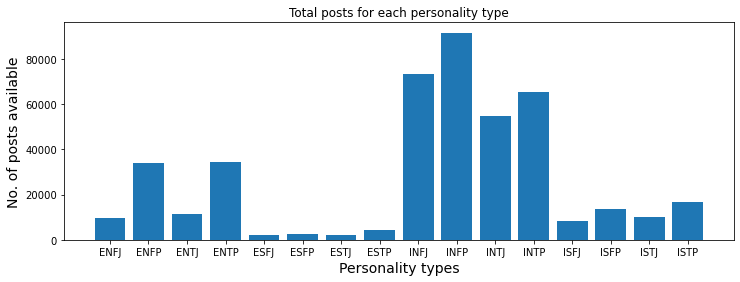

In [82]:
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

In [84]:
df = df_t.copy

In [86]:
def preprocess_text(df, remove_special=True):
    texts = df['posts'].copy()
    labels = df['type'].copy()

    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert posts to lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repeating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove MBTI Personality Words - crutial in order to get valid model accuracy estimation for unseen data. 
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")
    
    return df

#Preprocessing of entered Text
new_df = preprocess_text(df_t)

In [87]:
#Remove posts with less than X words
min_words = 15
print("Before : Number of posts", len(new_df)) 
new_df["no. of. words"] = new_df["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
new_df = new_df[new_df["no. of. words"] >= min_words]

print("After : Number of posts", len(new_df))


Before : Number of posts 8675
After : Number of posts 8466


In [88]:
# Converting MBTI personality (or target or Y feature) into numerical form using Label Encoding
# encoding personality type
enc = LabelEncoder()
new_df['type of encoding'] = enc.fit_transform(new_df['type'])

target = new_df['type of encoding'] 

In [91]:
# Vectorizing the posts for the model and filtering Stop-words
vect = CountVectorizer(stop_words='english') 

# Converting posts (or training or X feature) into numerical form by count vectorization
train =  vect.fit_transform(new_df["posts"])

In [92]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, stratify=target, random_state=42)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(5079, 98555) (5079,) (3387, 98555) (3387,)


In [98]:
accuracies = {}

#Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state = 1)
random_forest.fit(X_train, y_train)

# make predictions for test data
Y_pred = random_forest.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Random Forest'] = accuracy* 100.0 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 39.53%


In [105]:
#XG boost Classifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

Y_pred = xgb.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['XG Boost'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 57.12%


In [109]:
#Gradient Descent
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, y_train)

Y_pred = sgd.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Gradient Descent'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 42.70%


In [113]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Logistic Regression'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 57.16%


Accuracy: 16.96%


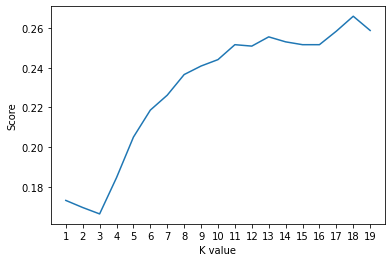

Maximum KNN Score is 26.59%


In [114]:
#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['KNN'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#try to find best k value
scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test, y_test))
    
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100

print("Maximum KNN Score is {:.2f}%".format(acc))


In [115]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X_train, y_train)

Y_pred = svm.predict(X_test)

predictions = [round(value) for value in Y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['SVM'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 35.76%


In [116]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, stratify=target, random_state=42)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(5672, 98555) (5672,) (2794, 98555) (2794,)


In [117]:
accuracies = {}

#Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state = 1)
random_forest.fit(X_train, y_train)

# make predictions for test data
Y_pred = random_forest.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Random Forest'] = accuracy* 100.0 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 37.87%


In [118]:
#XG boost Classifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

Y_pred = xgb.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['XG Boost'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 57.12%


In [119]:
#Gradient Descent
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, y_train)

Y_pred = sgd.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Gradient Descent'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 33.64%


In [120]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Logistic Regression'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 57.16%


Accuracy: 16.96%


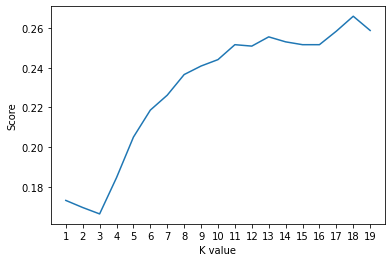

Maximum KNN Score is 26.59%


In [121]:
#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['KNN'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#try to find best k value
scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test, y_test))
    
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100

print("Maximum KNN Score is {:.2f}%".format(acc))


In [122]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X_train, y_train)

Y_pred = svm.predict(X_test)

predictions = [round(value) for value in Y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['SVM'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 35.76%


In [123]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data = df_t.join(df_t.apply (lambda row: get_types (row),axis=1))
data.head(5)

,type,posts,word_count,no. of. words,IE,NS,TF,JP
0,INFJ,enfp intj moments sportscenter plays...,556,430,1,1,0,1
1,ENTP,finding lack these posts very alarming eo...,1170,803,0,1,1,0
2,INTP,good course which know thats bles...,836,253,1,1,1,0
3,INTJ,dear intp enjoyed conversation other eos...,1064,777,1,1,1,1
4,ENTJ,youre fired eostokendot thats another silly...,967,402,0,1,1,1


In [143]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/csy/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [144]:
lemmatiser = WordNetLemmatizer()

# Remove the stop words for speed 
useless_words = stopwords.words("english")

# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]

# Or we can use Label Encoding (as above) of this unique personality type indicator list
# from sklearn.preprocessing import LabelEncoder
# unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
#        'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
# lab_encoder = LabelEncoder().fit(unique_type_list)

In [145]:
# Splitting the MBTI personality into 4 letters and binarizing it

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [b_Pers[l] for l in personality]

#To show result output for personality prediction
def translate_back(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [149]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/csy/nltk_data...


True

In [150]:
def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_data = len(data)
  i=0
  
  for row in data.iterrows():
      # check code working 
      # i+=1
      # if (i % 500 == 0 or i == 1 or i == len_data):
      #     print("%s of %s rows" % (i, len_data))

      #Remove and clean comments
      posts = row[1].posts

      #Remove url links 
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

      #Remove Non-words - keep only words
      temp = re.sub("[^a-zA-Z]", " ", temp)

      # Remove spaces > 1
      temp = re.sub(' +', ' ', temp).lower()

      #Remove multiple letter repeating words
      temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

      #Remove stop words
      if remove_stop_words:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
      else:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
          
      #Remove MBTI personality words from posts
      if remove_mbti_profiles:
          for t in unique_type_list:
              temp = temp.replace(t,"")

      # transform mbti to binary vector
      type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
      list_personality.append(type_labelized)
      # the cleaned data temp is passed here
      list_posts.append(temp)

  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

list_posts, list_personality  = pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", data.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", data.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])

Example :

Post before preprocessing:

     enfp  intj moments   sportscenter    plays   pranks   what  been  most lifechanging experience  your life eostokenquest        repeat  most  today eostokendot      perc experience immerse  eostokendot     last thing  infj friend posted   facebook before committing suicide  next  eostokendot  rest  peace     hello enfj eostokendot  sorry  hear  your distress eostokendot   only natural   relationship    perfection   time  every moment  existence eostokendot    figure  hard times  times  growth  eostokendot  eostokendot  eostokendot          eostokendot  eostokendot  eostokendot    welcome  stuff eostokendot     game eostokendot   eostokendot  match eostokendot    prozac wellbrutin  least thirty minutes  moving your legs   dont mean moving them while sitting  your same desk chair weed  moderation maybe  edibles   healthier alternative eostokendot  eostokendot  eostokendot    basically come  with three items youve determined that each type  which

In [151]:
nRow, nCol = list_personality.shape
print(f'No. of posts = {nRow}  and No. of Personalities = {nCol} ')

No. of posts = 8675  and No. of Personalities = 4 


In [158]:
# Vectorizing the database posts to a matrix of token counts for the model
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1000,  
                             max_df=0.7,
                             min_df=0.1) 
# the feature should be made of word n-gram 
# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_posts)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names_out()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage :-
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'across'), (4, 'action'), (5, 'actually'), (6, 'advice'), (7, 'agree'), (8, 'almost'), (9, 'alone')]

Using Tf-idf :
Now the dataset size is as below
(8675, 533)


In [159]:
# Posts in tf-idf representation
X = X_tfidf

In [161]:
personality_type = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", 
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])


IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)


In [162]:
#Random Forest model for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.33%
NS: Intuition (N) / Sensing (S) Accuracy: 86.03%
FT: Feeling (F) / Thinking (T) Accuracy: 67.87%
JP: Judging (J) / Perceiving (P) Accuracy: 61.33%


In [163]:
# setup parameters for xgboost
param = {}

param['n_estimators'] = 200 #100
param['max_depth'] = 2 #3
param['nthread'] = 8 #1
param['learning_rate'] = 0.2 #0.1

# Individually training each mbti personlity type
for l in range(len(personality_type)):
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.30%
NS: Intuition (N) / Sensing (S) Accuracy: 85.85%
FT: Feeling (F) / Thinking (T) Accuracy: 68.29%
JP: Judging (J) / Perceiving (P) Accuracy: 61.72%


In [164]:
my_posts  = """ Hi I am 21 years, currently, I am pursuing my graduate degree in computer science and management (Mba Tech CS ), It is a 5-year dual degree.... My CGPA to date is 3.8/4.0 . I have a passion for teaching since childhood. Math has always been the subject of my interest in school. Also, my mother has been one of my biggest inspirations for me. She started her career as a teacher and now has her own education trust with preschools schools in Rural and Urban areas. During the period of lockdown, I dwelled in the field of blogging and content creation on Instagram.  to spread love positivity kindness . I hope I am able deliver my best to the platform and my optimistic attitude helps in the growth that is expected. Thank you for the opportunity. """

# The type is just a dummy so that the data prep function can be reused
mydata = pd.DataFrame(data={'type': ['INFJ'], 'posts': [my_posts]})

my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [165]:
# setup parameters for xgboost
param = {}
param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

#XGBoost model for MBTI dataset
result = []
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    print("%s classifier trained" % (personality_type[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])

IE: Introversion (I) / Extroversion (E) classifier trained
NS: Intuition (N) / Sensing (S) classifier trained
FT: Feeling (F) / Thinking (T) classifier trained
JP: Judging (J) / Perceiving (P) classifier trained


In [166]:
print("The result is: ", translate_back(result))

The result is:  INFJ


In [167]:
my_posts = """ They act like they care They tell me to share But when I carve the stories on my arm The doctor just calls it self harm I’m not asking for attention There’s a reason I have apprehensions I just need you to see What has become of me||| I know I’m going crazy But they think my thoughts are just hazy When in that chaos, in that confusion I’m crying out for help, to escape my delusions||| Mental health is a state of mind How does one keep that up when assistance is denied All my failed attempts to fight the blaze You treat it like its a passing phase||| Well stop, its not, because mental illness is real Understand that we’re all not made of steel Because when you brush these issues under the carpet You make it seem like its our mistake we’re not guarded||| Don’t you realise that its a problem that needs to be addressed Starting at home, in our nest Why do you keep your mouths shut about such things Instead of caring for those with broken wings||| What use is this social stigma When mental illness is not even such an enigma Look around and you’ll see the numbers of the affected hiding under the covers ||| This is an issue that needs to be discussed Not looked down upon with disgust Mental illness needs to be accepted So that people can be protected ||| Let me give you some direction People need affection The darkness must be escaped Only then the lost can be saved||| Bring in a change Something not very strange The new year is here Its time to eradicate fear||| Recognise the wrists under the knives To stop mental illness from taking more lives Let’s break the convention Start ‘suicide prevention’.||| Hoping the festival of lights drives the darkness of mental illness away"""
mydata = pd.DataFrame(data={'type': ['INFP'], 'posts': [my_posts]})
my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)
my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [168]:
# setup parameters for xgboost
param = {}
param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

#XGBoost model for MBTI dataset
result = []
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    print("%s classifier trained" % (personality_type[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])

IE: Introversion (I) / Extroversion (E) classifier trained
NS: Intuition (N) / Sensing (S) classifier trained
FT: Feeling (F) / Thinking (T) classifier trained
JP: Judging (J) / Perceiving (P) classifier trained


In [169]:
my_posts  = """ I dont think anyone would be able to live 300 years i am not talking about the physical ability to do so but the mental fortitude unless you decide to live away from civilization it simply is not possible.|||Believe me you would not want to live for that long alone , unless there are others who can live for 300 years as well.|||You cannot enjoy something if you say something to yourself like ‘I wanna enjoy this , i think this thing is gonna be fun’ believe me it doesn’t work.|||I think this problem might be face by a lot of people.|||Firstly you should only study stuff that interests you . (obvious)|||Now there are subjects that you school forces you to take and you have no option but to some how score in those subjects. (What i used to think is subjects like history , geography and most of all Hindi are utterly useless , i wanna be a programmer why do i study these)|||But because i had no choice i thought lets give these a try. I started questioning things and when i dug deep into the events of history and and why each event took place or how it was of benefit to the benefactor. This questioning and finding out the reasons made me like history.|||My point is unless ya’ll start questioning and researching further than whats necessary for exams you wont like that subject. All the subjects are beautiful , its what you choose to see. Basically give everything a real shot in life , everything works out. (my advice seems ironical as if you dont like the subject and i am telling you to research further but try it once )|||And also never study because there is exam or because you have to do an assignment or because someone is told you to or because ….|||But please ONLY STUDY BECAUSE YOU FEEL LIKE AND BECAUSE YOU WANT TO. Until you develop this sense of want to study it will be hard for you to like it. You must like it so much , that you know when people say after studying maths for 1 hour they took a break of 20 mins watching their favorite tv show(lets say friends)|||For you it should be like after 1 hour of x(that you dont like but HAVE to do) activity you take a break of 20 mins and you study , (like i like reading article on ai so i do that) you might like bio you will do that what i want to say is that is what it means to like something and only then you can truly enjoy it.|||If only something known as luck existed. (no offence to the readers or person who asked the question)|||Luck is a really interesting term , a really complex illusion. What i am saying is there is nothing known as luck that exists. Something simply doesnt just happen. It happens for a reason and with a reason.|||Some over here might claim that if it is not luck then what is it that cause (cause a child to be born in a rich family or a person to be saved by weirdest phenomenon and escape death.)|||What i want ya’ll to know is firstly that being born rich cannot be called as “lucky” like we cannot say to be born in a rich family is particularly a good thing there are many reasons to this (some people like to work their way up , Some want to experience the life troubles, well whatever the reasons might be) So firstly when we say something to be lucky we just CONSIDER that what happened was good. Same goes with the case of being saved from and awful accident. We still dont know the purpose of life or our existence and hence we dont know if living is a boon. this might be harsh for some but Reality is Harsh.|||What want ya’ll to know is never feel bad if something good(in your perspective) happens to someone as It might as well not turn out to be good if you see the BIG picture.|||Besides its also a good thing to think this way as its boosts up your hopes , like you might consider that everything that has happened to you has made you what you are and even if you don’t appreciate your conditions there is someone somewhere who would want to be in that.|||I think the all of us are 100% selfish. (no offence)|||The thing is even if we say we care about someone and then we help that person in reality we are just making ourselves happy by helping that someone.|||What i mean to say is even when people talk about sacrifices for others the reality is that sacrifice made that person or those persons happy which you cared for and thus those people being happy makes you happy.|||Everything comes down to you. You can try and deny it but you all know it.|||Now about those people who sacrifice their lives for others that is a peculiar case , and here too (this might be hard for some to believe) but they sacrifice life for someone they loved (they thought they loved) but the truth is in a situation where a person sacrifices his life for another the truth is that if he hadnt dont that he couldn’t have survived without that person anyways and then there are always some who seek glory.|||I hope you get the point. Even when you say that people spend 30s and 40s the truth is making their kids life perfect gives them happiness. There are people without kids too cause for these making their kids life perfect doesnt give them as much happiness as focusing on their own goals might.|||Now i believe there might be many who thought that making kids life perfect might give them happiness but it turns out to be false and then they are stuck there fulfilling moral obligations. It all comes down to your resolves and how firm you are in you decisions.|||Isn’t it fun to watch our disciples fight among themselves to prove that only one of us exists!|||I tend to believe that everything in this universe HAS TO HAVE A PURPOSE. Rather than thinking that the universe is a useless place and we have no purpose i would rather think we are just too stupid and dont know or cannot find the purpose. I have always wondered that what would be our reason to exist , once i thought of us (humans on earth) a crop created by aliens that takes this long to grow (i mean may be it would be not possible to create humans by a process other than evolution) so the aliens started the life on earth and are now just waiting for us to evolve , and so our purpose according to that is nothing but to serve as food or may be what ever they want , now then the question arises is what would their purpose be , And all such hypothetical situation lead to to scenario to go into infinity.|||After a lot of such crazy thought i came to 2 conclusions , 1 is pretty simple our purpose of life is find a purpose for our lives , and the weird thing is unlike other things once you find what your were looking for , the process ends there. The paradox is after you find your purpose of life did your succeed in finishing your purpose of life or did you just begun ?|||The 2nd one is what most people should agree is happiness. Now I think that this happiness should be confined to YOUR’s and ONLY your Happiness. Now the thing is some people gain happiness by giving people happiness.|||Let happiness be a quantifiable entity. We shall say that we start 0 oh hp . |||The zone where we dont feel happy or sad is 0 . Anything above 0 means you are happy and less than 0 is you are sad .|||Now one might think that if we suppose attain 100 hp , and do nothing after that we shall remain happy , the problem is that after a while our bar above which we remain moves up (simple adaptation) so now anything below 100hp is sad . This is the main problem with happiness , and So we need to keep doing stuff and increasing our hp . So maybe this counts as a purpose of life.|||Like when we are told about those saints and stuff who abandon society and live their life alone in discrete places where no one can disturb them. I believe the simple reason for this they have found happiness in doing nothing . Like someone finds happiness in making more money (there is a possibility that you might not make and hence be sad ) So these saint type people do something that has no opposite , like i know when they do nothing (i know its opposite is everything) and thats the very reason they go away from the civilization where they literally will have to do nothing . I also tend to think of these people as cowards who fear that they might loose at point.|||But the very point arises is what did you gain by gaining happiness. So again there is no end so Keep chasing the infinity its pointless but Keeps you busy(till the point you are alive) then after you are dead i guess nothing matters.|||But anyways thats the most easy thing to obtain happiness without sadness.|||But the very point arises is what did you gain by gaining happiness. So again there is no end so Keep chasing the infinity its pointless but Keeps you busy(till the point you are alive) then after you are dead i guess nothing matters.|||But if the life after death theory is true , and if by chance are memories are also transferred every time we are reborn. We all are fucked We are for infinity stuck chasing the infinity . (I wonder what happens when infinity chases infinity It will be fun to watch !) |||I think rather than worrying about these things we should just enjoy life . Because there will always something that we dont know that we dont know and thus we shall never know that. this is just 2 loops of not know , you can reach it , but Do it infinitely . Infinity is a bitch.|||Well To all beings good luck finding a purpose and to all those who know that it doesnt exist ya’ll are fucked."""
mydata = pd.DataFrame(data={'type': ['ENTP'], 'posts': [my_posts]})
my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)
my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [170]:
# setup parameters for xgboost
param = {}
param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

#XGBoost model for MBTI dataset
result = []
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    print("%s classifier trained" % (personality_type[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])
    

IE: Introversion (I) / Extroversion (E) classifier trained
NS: Intuition (N) / Sensing (S) classifier trained
FT: Feeling (F) / Thinking (T) classifier trained
JP: Judging (J) / Perceiving (P) classifier trained


In [171]:
print("The result is: ", translate_back(result)) 


The result is:  INTP


https://www.kaggle.com/code/rajshreev/mbti-personality-predictor-using-machine-learning#MBTI-Personality-Prediction-Machine-Learning-Model



